In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
import xgboost as xgb
from functions import aux_functions

## Import imbalanced dataset

In [2]:
hardbounce = pd.read_csv('datasets/hardbounce_featureEngineering.csv',sep=';')

In [3]:
aux_functions.freqTable(
    hardbounce['flgHardBounce_n']
    ,""
    ,False
    ,"columns"
)

flgHardBounce_n
0    0.787886
1    0.212114
Name: __dummy__, dtype: float64

## Build dummy variables

In [4]:
cat_vars=['emailDomain_cat','emailDomainPiece1','emailDomainPiece2']

hardbounce_dummy = aux_functions.buildDummyVariables(hardbounce, cat_vars)

## Split dataset in Train / Test

In [5]:
x_vars = ['monthsSinceRegDate', 'age', 'percNumbersInEmailUser', 'emailUserCharQty', 
          'emailDomain_cat_gmail.com', 'emailDomain_cat_hotmail.com',
          'emailDomainPiece1_com',
          'emailDomainPiece2_br', 'emailDomainPiece2_missing']

X = hardbounce_dummy[x_vars]

y = hardbounce_dummy['flgHardBounce_n']

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(338377, 9)
(145019, 9)
(338377,)
(145019,)


## Apply Extreme Gradient Boosting Model

In [7]:
import pickle

xgb_model = pickle.load(open('models/xgb-classifier.sav', 'rb'))

### Probability Thresholds

(0, 1)

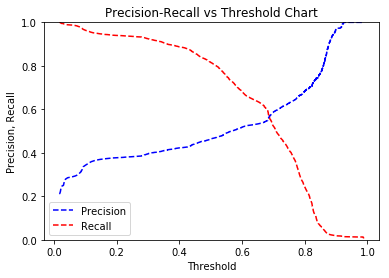

In [8]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Predict
y_scores_threshold = xgb_model.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores_threshold) 

#retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [9]:
# XGBoost Classifier predict

threshold = 0.6

y_pred = np.where(xgb_model.predict_proba(X_test)[:,1] > threshold, 1, 0)
y_scores = xgb_model.predict_proba(X_test)[:,1]

### F1-score, precision and recall

In [10]:
from sklearn.metrics import classification_report
target_names = hardbounce_dummy['flgHardBounce_n'].astype('str').unique()
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           1       0.91      0.83      0.87    114385
           0       0.52      0.68      0.59     30634

    accuracy                           0.80    145019
   macro avg       0.71      0.76      0.73    145019
weighted avg       0.82      0.80      0.81    145019



### Accuracy

In [11]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7986677607761742


### Plot Confusion Matrix

Confusion matrix, without normalization
[[94967 19418]
 [ 9779 20855]]


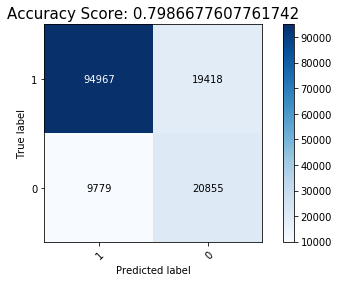

In [12]:
class_names = hardbounce_dummy['flgHardBounce_n'].astype('str').unique()
aux_functions.plot_confusion_matrix(y_test, y_pred, classes=class_names, cmap=plt.cm.Blues, normalize=False)

### AVG Precision Score

In [13]:
print("AVG Precision Score: ", metrics.average_precision_score(y_test, y_scores))

AVG Precision Score:  0.5882624906424684


### AUC

In [14]:
auc_metric = metrics.roc_auc_score(y_test, y_scores)
print("AUC: %.4f" % auc_metric)

AUC: 0.8571


### ROC Curve

AUC: 0.8571


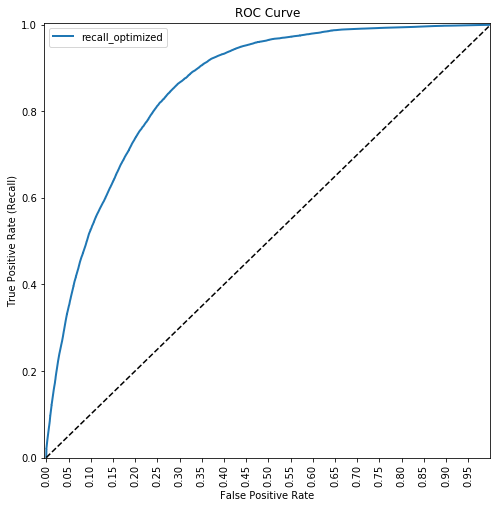

In [15]:
fpr, tpr, auc_thresholds = metrics.roc_curve(y_test, y_scores)
print("AUC: %.4f" % metrics.auc(fpr, tpr)) # AUC of ROC
aux_functions.plot_roc_curve(fpr, tpr, 'recall_optimized')